## Test of different radiative models in capturing the NDSI / FSC observed dynamics

This experiment also allows us to understand the uncertainty associated to the NDSI-FSC coversion 

We consider a model for retrieving fractional snow cover from observations:
- One pixel is composed by soil, snow, and vegetation in a variable fraction (endmembers).
- We consider different spectral mixing that express the total reflectance of that pixel as a combination of the endmembers reflectances
- We perform a Montecarlo simulation of the NDSI for one pixel from these models. Each iteration can be summarized with these steps:
1. Pick a random snow fraction between 1% and 100%
2. Pick a random value of VIS and SWIR reflectances of the endmembers from some reflectance distributions previously calibrated
3. Compute VIS and SWIR reflectances of the pixel using one of the models
4. Compute NDSI
- We make a scatter plot of the NDSI - FSC pairs generated for each simulation

In other words, we simulate (simple) radiative forward models between FSC and NDSI. We compare these simulations to the retrieval  NDSI -> FSC approaches, formulated without assuming any forward model but fitting the observations.
This way we can:
- Have an idea of the uncertainty of NDSI based approaches, depending on the forward model chosen 
- The ability of the different models to capture real observations (NDSI - FSC scatter plots from the litterature)

Calibration of endmembers reflectance distribution from two VIIRS images
In practice we plot the histogram for these images for vegetation, no vegetation and snow cover, and try to fit a normal distribution to the histogram. This will give us a mean and std to use for the Montecarlo simulation

In [30]:
from dataclasses import dataclass

@dataclass
class EndMember:
    mu: float
    sigma: float

@dataclass
class BandEM:
    forest: EndMember
    soil: EndMember
    snow: EndMember




In [ ]:
import xarray as xr
import rasterio

forest_mask = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/forest_mask/corine_2006_forest_mask_geo.tif').read(1)
roi_mask=rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem/MSF_MASK_FRANCE_GEO_375m.tif').read(1)
# red_band = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/CMS_rejeu/red_band/202402/20240213_1202_1216_npp_latlon_-5.0033746_40.996626_10.0033746_51.496626_I01.tif').read(1)
red_band = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/data/V02IMG/VNP02IMG_GEO_375m/VNP02IMG_GEO_375m.A2024044.1206.002.2024044204638.nc').data_vars['I01'].where(roi_mask)/np.cos(np.deg2rad(60))*100
swir_band = xr.open_dataset('/home/imperatoren/work/VIIRS_S2_comparison/data/V02IMG/VNP02IMG_GEO_375m/VNP02IMG_GEO_375m.A2024044.1206.002.2024044204638.nc').data_vars['I03'].where(roi_mask)/np.cos(np.deg2rad(60))*100

snow_cover = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/CMS_rejeu/202402/20240213_120329_npp_produit_synopsis.tif').read(1)*roi_mask

red_veg = np.where(forest_mask * (snow_cover==0), red_band, np.nan).flatten()
red_soil = np.where((1-forest_mask) * (snow_cover==0), red_band, np.nan).flatten()
red_snow = np.where((1-forest_mask) * (snow_cover==200), red_band, np.nan).flatten()


swir_veg = np.where(forest_mask * (snow_cover==0), swir_band, np.nan).flatten()
swir_soil = np.where((1-forest_mask) * (snow_cover==0), swir_band, np.nan).flatten()
swir_snow = np.where((1-forest_mask) * (snow_cover==200), swir_band, np.nan).flatten()



/tmp/ipykernel_20333/840532731.py:10: RuntimeWarning: overflow encountered in multiply
  snow_cover = rasterio.open('/home/imperatoren/work/VIIRS_S2_comparison/data/CMS_rejeu/202402/20240213_120329_npp_produit_synopsis.tif').read(1)*roi_mask


In [34]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np

def calibrate_normal_distirbution_to_histogram(image: np.array, mu:float, sigma:float, n_points:int=10000,ax: Axes | None =None):
    if ax is None:
        fig, ax=plt.subplots()
    h = np.histogram(image,bins=np.arange(100,step=0.05))
    ax.plot(np.arange(100,step=0.05)[:-1],h[0]/np.max(h[0]),label="satellite")
    sim = np.random.normal(loc=mu, scale=sigma, size=(n_points,))
    h = np.histogram(sim,bins=np.arange(100,step=0.05))
    ax.plot(np.arange(100,step=0.05)[:-1],h[0]/np.max(h[0]),label="simulation")
    ax.legend()

red = BandEM(forest=EndMember(mu=7, sigma=1.5),soil=EndMember(mu=8,sigma=1.5), snow=EndMember(mu=60, sigma=30))
swir = BandEM(forest=EndMember(mu=16, sigma=5),soil=EndMember(mu=18,sigma=6), snow=EndMember(mu=6, sigma=5))

Text(0.5, 1.0, 'Red band snow')

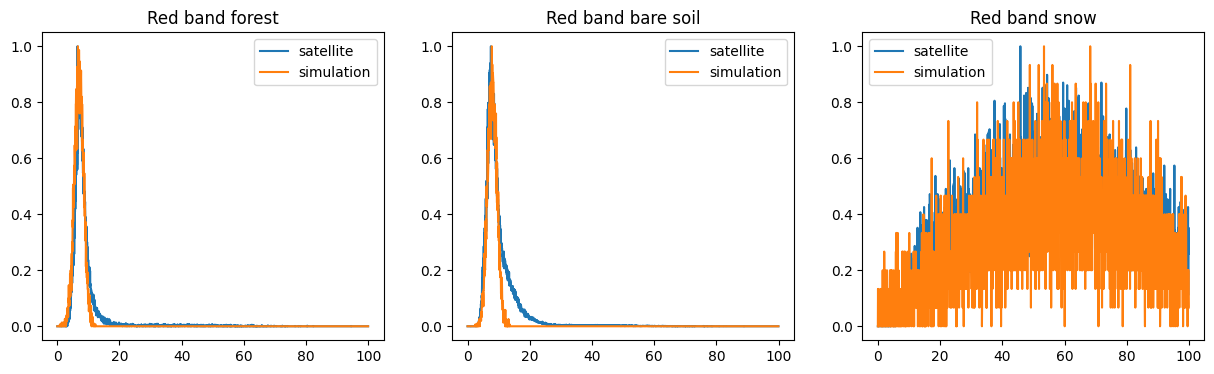

In [32]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
calibrate_normal_distirbution_to_histogram(image=red_veg, mu=red.forest.mu, sigma=red.forest.sigma, ax=axs[0])
axs[0].set_title("Red band forest")
calibrate_normal_distirbution_to_histogram(image=red_soil, mu=red.soil.mu, sigma=red.soil.sigma, ax=axs[1])
axs[1].set_title("Red band bare soil")
calibrate_normal_distirbution_to_histogram(image=red_snow, mu=red.snow.mu, sigma=red.snow.sigma, ax=axs[2])
axs[2].set_title("Red band snow")


Text(0.5, 1.0, 'SWIR band snow')

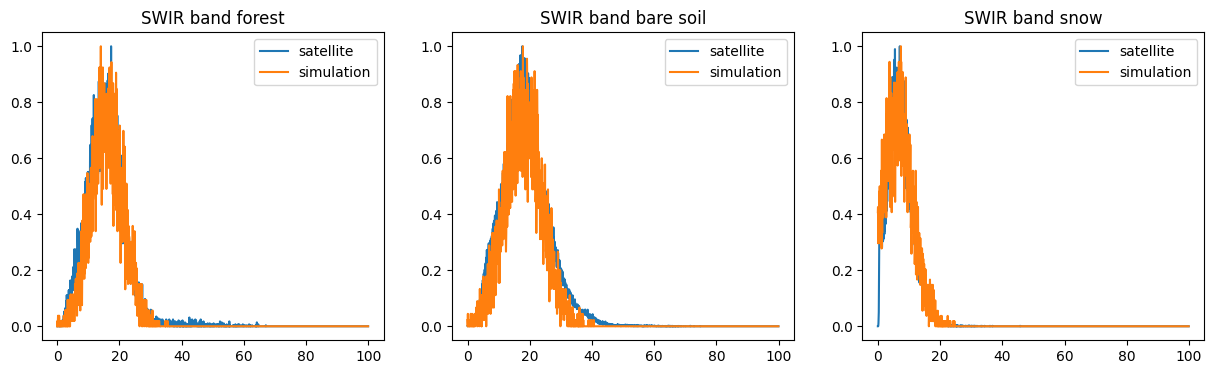

In [35]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
calibrate_normal_distirbution_to_histogram(image=swir_veg, mu=swir.forest.mu, sigma=swir.forest.sigma, ax=axs[0])
axs[0].set_title("SWIR band forest")
calibrate_normal_distirbution_to_histogram(image=swir_soil, mu=swir.soil.mu, sigma=swir.soil.sigma, ax=axs[1])
axs[1].set_title("SWIR band bare soil")
calibrate_normal_distirbution_to_histogram(image=swir_snow, mu=swir.snow.mu, sigma=swir.snow.sigma, ax=axs[2])
axs[2].set_title("SWIR band snow")


Define some spectral mixing models used in litterature

In [ ]:
def compute_test_ndsi_scamod(rho_wet_snow_g: float=0.9, 
                             rho_wet_snow_swir: float=0, 
                             rho_veg_g:float=0.3, 
                             rho_veg_swir:float=0.3, 
                             rho_soil_g:float=0.3, 
                             rho_soil_swir:float=0.5,
                             t2_g: float=0.5,
                             t2_swir:float=0.5,
                             f_snow:float=0.5,
                             ):
    """SCAmod algorithm (Metsämäki et al. 2012).
    In use for VIIRS Northern emisphere CLMS.
    A transmittivity term t2 characterizes the scattering in the forest.
    This transmittivity term has to be estimated spatially.
    """
    # Generate snow fractions
    rho_g = rho_veg_g * (1-t2_g)  + t2_g*(f_snow*rho_wet_snow_g + (1-f_snow)*rho_soil_g)
    rho_swir = rho_veg_swir * (1-t2_swir)  + t2_swir*(f_snow*rho_wet_snow_swir + (1-f_snow)*rho_soil_swir)
    return (rho_g - rho_swir) / (rho_g + rho_swir)

def compute_test_ndsi_lin(f_veg: float, 
                          rho_snow_g: float=0.9, 
                          rho_snow_swir: float=0, 
                          rho_veg_g:float=0.3, 
                          rho_veg_swir:float=0.3, 
                          rho_soil_g:float=0.3, 
                          rho_soil_swir:float=0.5,
                          f_snow:float=0.5):
    """Linear mix model:
       Total reflectance as a linear combination of endmembers reflectances weighted by their fraction.
       See publications on MODSCAG
    """
    # Generate snow fractions
    f_soil = 1 - f_veg - f_snow
    rho_g = rho_snow_g * f_snow + rho_veg_g * f_veg + rho_soil_g * f_soil
    rho_swir = rho_snow_swir * f_snow + rho_veg_swir * f_veg + rho_soil_swir * f_soil
    return (rho_g - rho_swir) / (rho_g + rho_swir)

def compute_test_ndsi_lin_toc( f_veg: float, 
                              rho_snow_g: float=0.9, 
                              rho_snow_swir: float=0, 
                              rho_veg_g:float=0.3, 
                              rho_veg_swir:float=0.3, 
                              rho_soil_g:float=0.3, 
                              rho_soil_swir:float=0.5,
                              f_snow:float=0.5):
    """Linear mix model separating top of canopy and on ground snow.
       We assume that all snow is on ground. 
       The snow on the top of the canopy is estimated by linearly reducing the snow on ground with the fraction of vegetation
       The inverse correction is in use for Sentinel-2 (Gascoin et al. 2021, Muhuri et al. 2021 )
    """
    # Generate snow fractions
    f_snow_og = f_snow
    f_soil = 1 - f_veg - f_snow_og
    f_snow_toc = f_snow_og*(1-f_veg)
    rho_g = rho_snow_g * f_snow_toc + rho_veg_g * f_veg + rho_soil_g * f_soil
    rho_swir = rho_snow_swir * f_snow_toc + rho_veg_swir * f_veg + rho_soil_swir * f_soil
    return (rho_g - rho_swir) / (rho_g + rho_swir)

def generate_landcover_simulation(n_sim:int=10_000):
    rho_snow_g = np.random.normal(loc=0.60, scale=0.3, size=(n_sim,))
    rho_snow_swir = np.random.normal(loc=0.06, scale=0.05, size=(n_sim,))
    rho_soil_g = np.random.normal(loc=0.075, scale=0.018, size=(n_sim,))
    rho_soil_swir = np.random.normal(loc=0.18, scale=0.06, size=(n_sim,))
    rho_veg_g = np.random.normal(loc=0.07, scale=0.015, size=(n_sim,))
    rho_veg_swir = np.random.normal(loc=0.16, scale=0.05, size=(n_sim,))
    return rho_soil_g,rho_veg_g,rho_snow_g,rho_soil_swir,rho_snow_swir,rho_veg_swir



Without vegetation

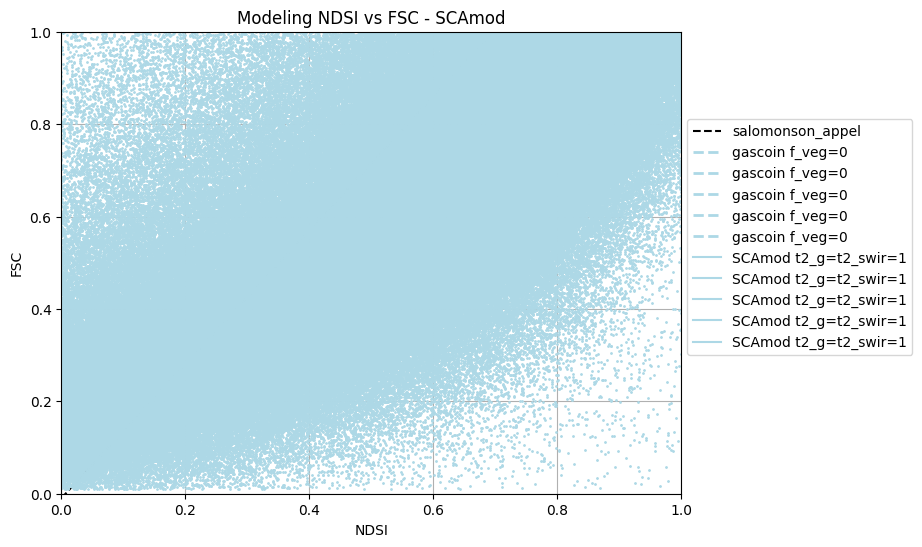

In [ ]:

f_veg = [0,0,0,0,0]#,*np.arange(0.2,0.8,0.05)]   
# f_veg = np.arange(0.2,0.85,0.05)

manual_legends=[]

N=100_000
ndsi_test_linear = np.zeros(shape=(N,))
ndsi_test_toc = np.zeros(shape=(N,))
ndsi_test_scamod = np.zeros(shape=(N,))
f_snow_test = np.zeros(shape=(N,))


for idx, (test_rho_soil_g, test_rho_veg_g,test_rho_snow_g, test_rho_soil_swir, test_rho_snow_swir, test_rho_veg_swir) in enumerate(zip(*generate_landcover_simulation(N))):
    # print(test_rho_soil_g, test_rho_veg_g,test_rho_snow_g, test_rho_soil_swir, test_rho_snow_swir, test_rho_veg_swir)
    # Transmittivity is brutally imposed equal to the non-forest fraction
    fsc = np.random.uniform(0.01,1)
    f_snow_test[idx]=fsc
    ndsi_test[idx] = compute_test_ndsi_scamod(rho_soil_g=test_rho_soil_g,
                                                    rho_soil_swir=test_rho_soil_swir, 
                                                    rho_wet_snow_g=test_rho_snow_g, 
                                                    rho_wet_snow_swir=test_rho_snow_swir,
                                                    rho_veg_swir=test_rho_veg_swir,
                                                    rho_veg_g=test_rho_veg_g,
                                                    f_snow=fsc,
                                                    t2_g=1,
                                                    t2_swir=1,
                                                    )
    ndsi_test[idx] = compute_test_ndsi_lin(f_veg=0,
                                            rho_soil_g=test_rho_soil_g,
                                            rho_soil_swir=test_rho_soil_swir,
                                            rho_snow_g=test_rho_snow_g,
                                            rho_snow_swir=test_rho_snow_swir,
                                            rho_veg_g=test_rho_veg_g,
                                            rho_veg_swir=test_rho_veg_swir,
                                            f_snow=fsc)
    ndsi_test[idx] = compute_test_ndsi_lin_toc(f_veg=0,
                                    rho_soil_g=test_rho_soil_g,
                                    rho_soil_swir=test_rho_soil_swir,
                                    rho_snow_g=test_rho_snow_g,
                                    rho_snow_swir=test_rho_snow_swir,
                                    rho_veg_g=test_rho_veg_g,
                                    rho_veg_swir=test_rho_veg_swir,
                                    f_snow=fsc)
# ax.plot(ndsi_test, f_snow_test, '.',markersize=2, color='lightblue')
# manual_legends.append(Line2D([0], [0], label=f'SCAmod t2_g=t2_swir={1-test_f_veg}', color='lightblue'))

# ax.set_xlabel('NDSI')
# ax.set_ylabel('FSC')
# ax.grid(True)
# ax.set_ylim(0,1)
# ax.set_xlim(0,1)
# handles, labels = ax.get_legend_handles_labels()
# handles.extend(manual_legends)
# ax.legend(handles=handles,loc=(1.01,0.3))
# ax.set_title("Modeling NDSI vs FSC - SCAmod")

In [27]:
def salomonson_appel(ndsi):
    return 1.45*ndsi - 0.01

def gascoin(ndsi, f_veg):
    f_snow_toc = 0.5 * np.tanh(2.65*ndsi - 1.42) + 0.5
    return np.minimum(1, f_snow_toc/(1-f_veg))

In [ ]:
# Generate Salomonson and Appel reference line 
ndsi_ref = np.linspace(0,1,1000)
fsc_salomonson = salomonson_appel(ndsi_ref)

fsc_gascoin = gascoin(ndsi_ref, test_f_veg)
ax.plot(ndsi_ref, fsc_gascoin,'--',linewidth=2,color='lightblue', label=f'gascoin f_veg={test_f_veg}')

The linear mixing model looks uncapable of capturing the observed NDSI behaviour with these settings:
- The curves for no vegetation do not really seem to capture the "sigmoid" behaviour commonly observed in NDSI vs FSC scatter plots (this is the case for also the other models)
- As the vegetation increases, the curves do not really move towards Salomonson and Appel nor Gascoin's fits.
- For high vegetation cover, we have a series of "unrealistic" simulations: FSC <1 for NDSI -> 1 in the forest...it looks not really logic

Applying a tree cover correction seems to enhance the linear mixing method, going to cover the upper left part of the NDSI-FSC plot commonly observed in forested areas. However, the errors in case of high vegetation cover.
The unrealistic relations for high f_veg are still there.

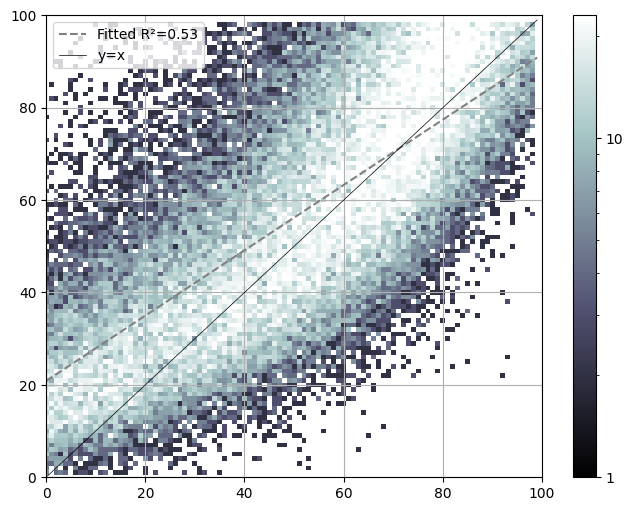

In [ ]:
import xarray as xr

from postprocess.scatter_plot import fancy_scatter_plot

ax.plot(ndsi_ref, fsc_salomonson, '--k',label='salomonson_appel')
fig, ax = plt.subplots(figsize=(8,6))
hist = np.histogram2d(f_snow_test*100, ndsi_test*100, bins=(np.arange(0,100),np.arange(0,100)))
simulated_scatter_plot = xr.DataArray(data=hist[0].T, coords={'x': hist[1][:-1], 'y':hist[2][:-1]})
fancy_scatter_plot(data_to_plt=simulated_scatter_plot, ax=ax,figure=fig,smoothing_window_size=0, low_threshold=2)


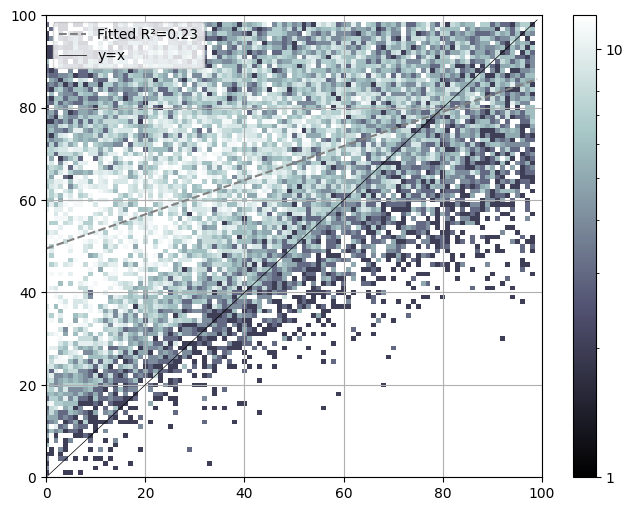

In [120]:
import xarray as xr

from postprocess.scatter_plot import fancy_scatter_plot

fig, ax = plt.subplots(figsize=(8,6))
hist = np.histogram2d(f_snow_test*100, ndsi_test*100, bins=(np.arange(0,100),np.arange(0,100)))
simulated_scatter_plot = xr.DataArray(data=hist[0].T, coords={'x': hist[1][:-1], 'y':hist[2][:-1]})
fancy_scatter_plot(data_to_plt=simulated_scatter_plot, ax=ax,figure=fig,smoothing_window_size=0, low_threshold=2)


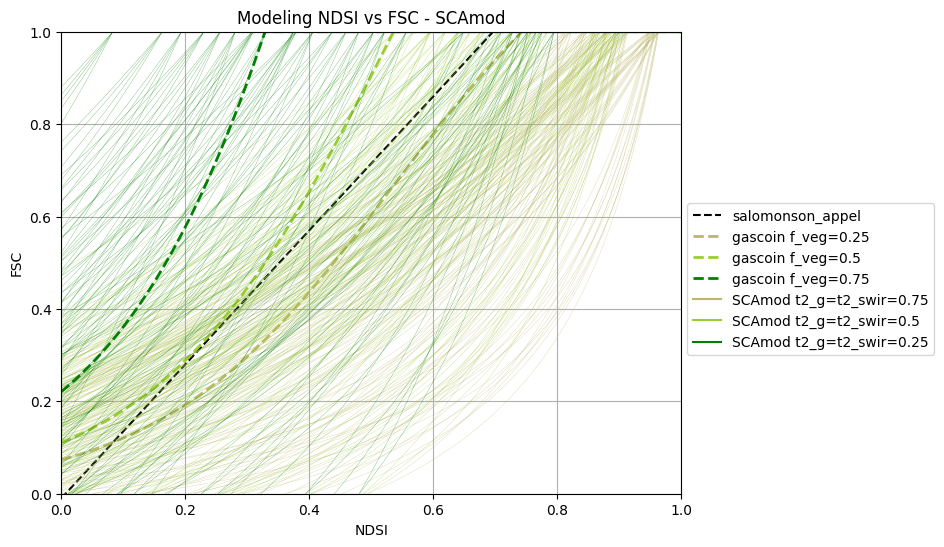

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
colors = ['saddlebrown', 'darkkhaki','yellowgreen', 'green']
ax.plot(ndsi_ref, fsc_salomonson, '--k',label='salomonson_appel')
manual_legends=[]
for test_f_veg, color in zip(f_veg[1:], colors[1:]):
    # S2 regression with true cover density correction
    fsc_gascoin = gascoin(ndsi_ref, test_f_veg)
    ax.plot(ndsi_ref, fsc_gascoin,'--',linewidth=2,color=color, label=f'gascoin f_veg={test_f_veg}')
    np.random.normal(loc=)
    for comb in possible_combinations[::2]:
        test_rho_soil_g, test_rho_veg_g, test_rho_soil_swir, test_rho_snow_g, test_rho_veg_swir  = comb

        # Transmittivity is brutally imposed equal to the non-forest fraction

        f_snow_test, ndsi_test = compute_test_ndsi_scamod(rho_soil_g=test_rho_soil_g,
                                                        rho_soil_swir=test_rho_soil_swir, 
                                                        rho_wet_snow_g=test_rho_snow_g, 
                                                        rho_wet_snow_swir=rho_snow_swir,
                                                        rho_veg_swir=test_rho_veg_swir,
                                                        rho_veg_g=test_rho_veg_g,
                                                        t2_g=1-test_f_veg,
                                                        t2_swir=1-test_f_veg)
        ax.plot(ndsi_test, f_snow_test, linewidth=0.15, color=color)
    manual_legends.append(Line2D([0], [0], label=f'SCAmod t2_g=t2_swir={1-test_f_veg}', color=color))

    ax.set_xlabel('NDSI')
    ax.set_ylabel('FSC')
    ax.grid(True)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(manual_legends)
    ax.legend(handles=handles,loc=(1.01,0.3))
    ax.set_title("Modeling NDSI vs FSC - SCAmod")

SCAmod forward model has a more stable dynamics in the forest. We get rid of unrealistic simulations at high f_veg.

### Conclusions

- The spectral unmixing methods are based on a linear mixing forward model. However, a linear unmixing forward model doesn't look to well describe the observed radiated light (NDSI) on a mixed pixel. Anyways, these methods use more bands and optimally look for the linear combination so isn't really the same thing.
- Salomonson and Appel regression might be a compromise between "no vegetation" and "full vegetation", as it limits the max error in both cases, but the RMSE introduced is generally high
- Introducing a correction for tree cover in the form of linear scaling or transmissivity might better desribe the transmitted light (and hence the observations).
- The NDSI approach for retrieving subpixel FSC in canopy might be a chimera...the sensitivity of NDSI to vegetation, soil is so high that for any regression we might fit the residual is still super high.